In [12]:
@time using CSV                          # CSVファイルの操作のためのパッケージ
@time using DataFrames                   # データフレーム
@time using Distributions                # 確率分布
@time using NLsolve                      # 非線形方程式の近似根を求める
@time using Plots                        # グラフ描画
@time using Parameters                   # 数値モデルのパラメーターを処理するために使用するパッケージ
@time using QuadGK                       # 1次元の数値積分
@time using SpecialFunctions             # 特殊関数
@time using StatsBase                    # 統計にかかわる基本的な関数群が提供されているパッケージ

  2.284160 seconds (5.57 M allocations: 321.505 MiB, 8.76% gc time, 90.17% compilation time)
  0.000143 seconds (108 allocations: 9.469 KiB)
  0.000054 seconds (108 allocations: 9.469 KiB)
  0.131148 seconds (422.33 k allocations: 25.892 MiB, 5.70% compilation time)
  0.000054 seconds (108 allocations: 9.469 KiB)
  0.000032 seconds (109 allocations: 9.516 KiB)
  0.000028 seconds (109 allocations: 9.516 KiB)
  0.000053 seconds (109 allocations: 9.531 KiB)
  0.000131 seconds (109 allocations: 9.516 KiB)


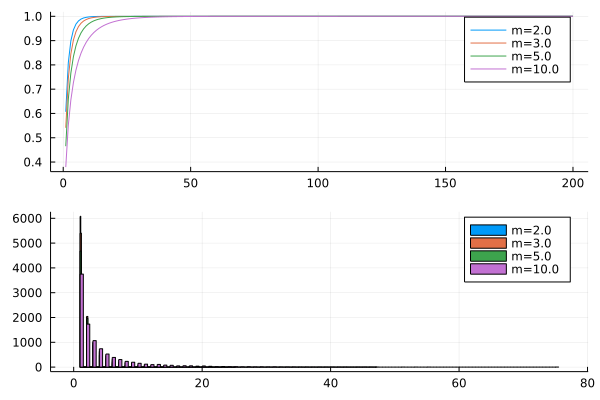

In [16]:
# 確率質量関数 ( PMF : probability mass function )
ρ(ω,m) = ω^m/(m*log(ω+1)*(ω+1)^m)

# 累積分布関数 ( CDF : cumulative distribution function )
function ζ(ω,M=200)
    x = zeros(M)
    cdf = 0.0
    for m in 1:M
        cdf += ρ(ω,m) 
        x[m] = cdf
    end
    return x
end

# イベントサイズ m
@inline function ξ(ω,x,M=200)
    y = rand(Uniform(0,1))
    if x[M] <= y[1] 
        m = M
    else
        for i in 1:M-1
            if x[i] >= y[1]
                m = i
                break
            else
                continue
            end
        end
    end
    return m
end;

#Plot
x1 = [ξ(2.0,ζ(2.0)) for i in 1:10000]
x2 = [ξ(3.0,ζ(3.0)) for i in 1:10000]
x3 = [ξ(5.0,ζ(5.0)) for i in 1:10000]
x4 = [ξ(10.0,ζ(10.0)) for i in 1:10000]

plt  = (plot(ζ(2.0),label="m=2.0") ; plot!(ζ(3.0),label="m=3.0") ; plot!(ζ(5.0),label="m=5.0") ; plot!(ζ(10.0),label="m=10.0"))
hist = histogram(x1,label="m=2.0") ; histogram!(x2,label="m=3.0") ; histogram!(x3,label="m=5.0") ; histogram!(x4,label="m=10.0")

plot(plt,hist,layout=(2,1))

時間伸縮法追加

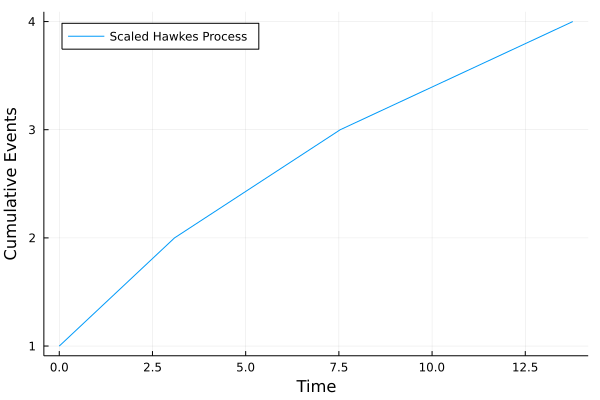

In [14]:
using Plots

function hawkes_intensity(t, alpha, beta, lambda0, past_events)
    """
    ホークス過程の強度関数を計算する関数
    """
    return lambda0 + alpha * sum(exp.(-beta * (t .- past_events)))
end

function time_scaling_method(T, alpha, beta, lambda0, scaling_factor)
    """
    時間伸縮法を用いたホークス過程のシミュレーション
    """
    scaled_T = T / scaling_factor
    scaled_lambda0 = lambda0 * scaling_factor
    t = [0.0]  # 初期時刻
    events = [1]  # イベントのリスト

    while t[end] < scaled_T
        next_event_time = t[end] - (1 / beta) * log(rand())
        intensity = hawkes_intensity(next_event_time, alpha, beta, scaled_lambda0, t)

        if rand() < intensity / (scaled_lambda0 + alpha * sum(exp.(-beta * (next_event_time .- t))))
            push!(t, next_event_time)
            push!(events, 1)
        end
    end

    # 時間のスケールを元に戻す
    t = t * scaling_factor

    return t, events
end

# パッケージのインポート
using Plots

# パラメータの設定
T = 10.0  # シミュレーションの時間範囲
alpha = 0.5  # ヒトの過去のイベントへの影響の強さ
beta = 1.0  # イベントの忘却係数
lambda0 = 0.1  # ベースの発生率
scaling_factor = 10.0  # 時間のスケールファクター

# 時間伸縮法を用いたホークス過程のシミュレーション
t_scaled, events_scaled = time_scaling_method(T, alpha, beta, lambda0, scaling_factor)

# 結果のプロット
plot(t_scaled, cumsum(events_scaled), xlabel="Time", ylabel="Cumulative Events", label="Scaled Hawkes Process", legend=:topleft)


二次元突入


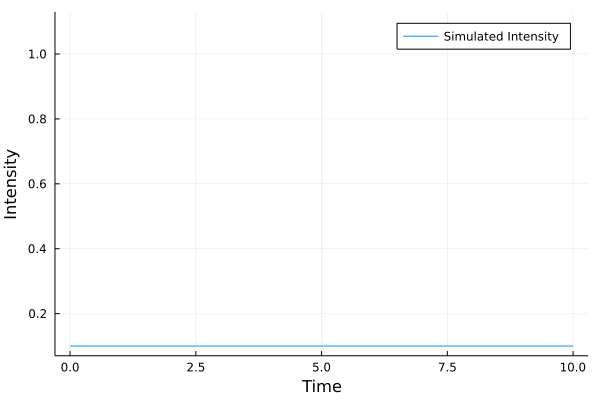

In [2]:

using Random
using Plots

# パラメータの設定
tau = 0.1  # 指数メモリーカーネルの時間定数
nu_0 = 0.1  # ベースライン強度
n = 5  # 分岐比

# シミュレーションのパラメータ
T = 10.0  # シミュレーションの時間
dt = 0.01  # タイムステップ

# 時間軸の生成
time = 0:dt:T

# ホークス過程のシミュレーション
function simulate_hawkes_process(tau, nu_0, n, T, dt)
    intensity = zeros(length(time))
    events = []

    for (i, t) in enumerate(time)
        # ポアソン過程に基づく事象の発生
        if rand() < nu_0 * dt
            push!(events, t)
        end

        # メモリーカーネルの影響を考慮
        for event_time in events
            intensity[i] += 1 / tau * exp(-(t - event_time) / tau)
        end
    end

    return intensity
end

# ホークス過程のシミュレーション実行
intensity_simulated = nu_0 .+ simulate_hawkes_process(tau, nu_0, n, T, dt)

# 結果のプロット
plot(time, intensity_simulated, label="Simulated Intensity", xlabel="Time", ylabel="Intensity", legend=true)



## 時間伸縮理論のアルゴリズム

・アルゴリズム\
時間伸縮理論を用いた、観察時間[0,T]における強度関数$\hat{ν}(t)$をもつホークス過程のシミュレーションアルゴリズムを以下に示す。
$$
hat{ν}(t) = ν_0 + n\sum_{i=1}^N h(t-\hat{t_i})
$$

1. i=1　
2. 期待値1の指数分布Ex(1)に従う乱数Eを生成し、イベント発生時刻$t_1=\frac{E}{ν_0}$とする。
３

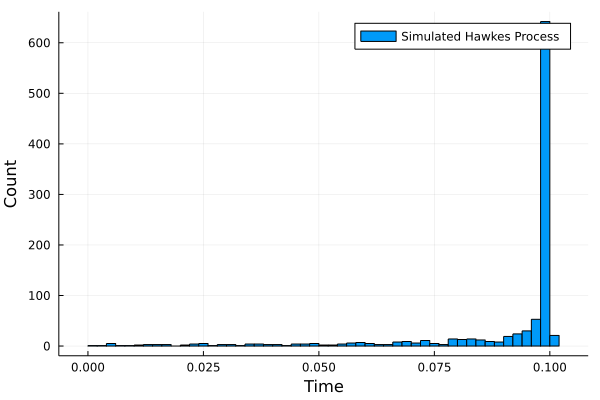

In [5]:
using Random
using Plots

# パラメータの設定
tau = 0.1  # 指数カーネルの時間定数
T = 10.0  # シミュレーションの時間
lambda_0 = 1.0  # ベースライン強度

# 到達時刻の時間変換関数
time_transformation(t) = lambda_0 * tau * (1 - exp(-t / tau))

# 標準指数分布に従う変換後の変数のシミュレーション
num_samples = 1000
u_values = -log.(1 .- rand(num_samples))

# 逆変換を適用して元の到達時刻を得る
original_arrival_times = time_transformation.(u_values)

# 結果のプロット
histogram(original_arrival_times, label="Simulated Hawkes Process", xlabel="Time", ylabel="Count", bins=50)

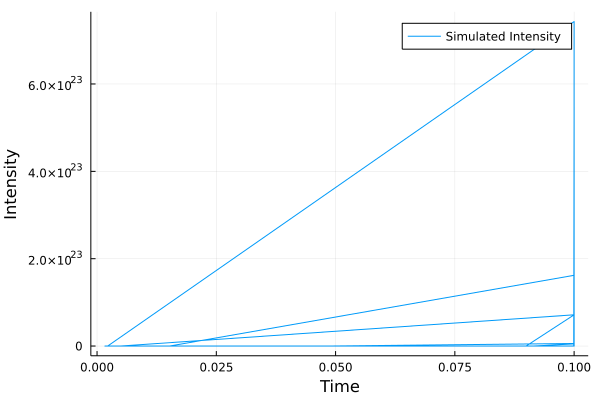

In [6]:
using Random
using Plots

# パラメータの設定
tau = 0.1  # 指数カーネルの時間定数
T = 10.0  # シミュレーションの時間
lambda_0 = 1.0  # ベースライン強度

# 到達時刻の時間変換関数
time_transformation(t) = lambda_0 * tau * (1 - exp(-t / tau))

# 標準指数分布に従う変換後の変数のシミュレーション
num_samples = 1000
u_values = -log.(1 .- rand(num_samples))

# 逆変換を適用して元の到達時刻を得る
original_arrival_times = time_transformation.(u_values)

# 強度の計算
intensity_values = [lambda_0 + tau * exp(-(t - u) / tau) for (t, u) in zip(original_arrival_times, u_values)]

# 結果のプロット
plot(original_arrival_times, intensity_values, label="Simulated Intensity", xlabel="Time", ylabel="Intensity")


In [2]:
using Random
using Distributions

$$
\hat{ν}^{1}(t)=ν_0+n^{1}_1\sum_{i=1}^{\hat{N_1}(t)} h_1(t-t^{1}_i)+n^{1}_2\sum_{j=1}^{\hat{N_2}(t)} h_2(t-t^{2}_j) \\
\hat{ν}^{2}(t)=ν_0+n^{2}_1\sum_{i=1}^{\hat{N_1}(t)} h_1(t-t^{1}_i)+n^{2}_2\sum_{j=1}^{\hat{N_2}(t)} h_2(t-t^{2}_j) 
$$

In [4]:
import Pkg
Pkg.add("Plots")


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


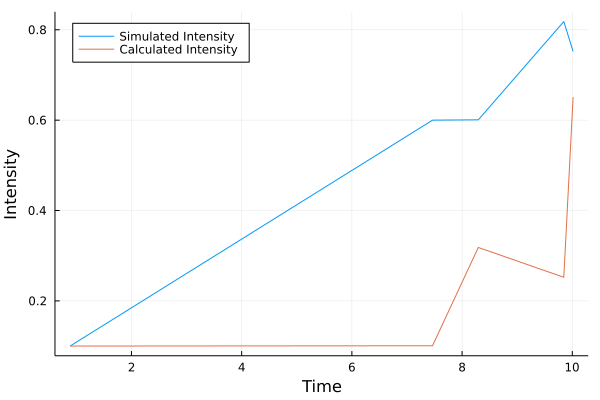

In [8]:
using Plots
using Random

function hawkes_process(lambda0, alpha, beta, T)
    t = 0.0
    events = Float64[]
    intensities = Float64[]
    
    while t < T
        lambda_t = lambda0 + alpha * sum(exp.(-beta * (t .- events)))
        next_event_time = t + rand(Exponential(1/lambda_t))
        
        push!(events, next_event_time)
        push!(intensities, lambda_t)
        
        t = next_event_time
    end
    
    return events, intensities
end

# パラメータ設定
lambda0 = 0.1  # 初期強度
alpha = 0.5    # カーネルの強度
beta = 1.0     # カーネルの減衰率
T = 10.0       # シミュレーションの時間

# ホークス過程のシミュレーション
events, intensities = hawkes_process(lambda0, alpha, beta, T)

# 強度の計算を修正
calculated_intensities = [lambda0 + alpha * sum(exp.(-beta * (t .- events[events .< t]))) for t in events]

# 結果のプロット
plot(events, intensities, xlabel="Time", ylabel="Intensity", label="Simulated Intensity", legend=:topleft)
plot!(events, calculated_intensities, label="Calculated Intensity")


In [13]:
# 非線形方程式 ( Non-linear equations )
@inline fun(t,λ0,λ,τ,ω,K,Δ) = λ0*t+sum([λ[i,1]*τ[i]*(1-exp(-t/τ[i])) for i in 1:K])-Δ*ω/log(ω+1)

# 解の導出 Find solutions to non-linear equations
@inline function nls(func, params...; ini = [0.0]) 
    if typeof(ini) <: Number
        r = nlsolve((vout,vin)->vout[1]=func(vin[1],params...), [ini])
        v = r.zero[1]
    else
        r = nlsolve((vout,vin)->vout .= func(vin,params...), ini)
        v = r.zero
    end
    return v, r.f_converged
end

nls(fun,0.01,0.99,1.0,2.0,1,rand(Exponential(1)),ini=0.0) # (近似根, true : 近似根 f=0 を満たす) 

(127.78415738962276, true)

  0.243056 seconds (929.75 k allocations: 40.670 MiB, 9.46% gc time, 96.94% compilation time)
  0.006849 seconds (318.37 k allocations: 8.356 MiB)


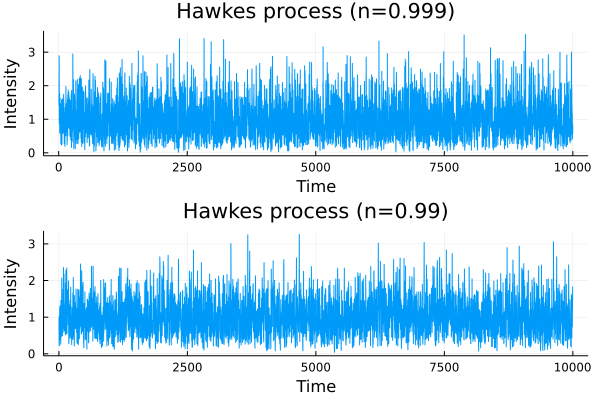

In [17]:
using Distributions
using DataFrames
using Plots

# Jump function
function jump(t, λ, τ, n)
    λ * exp(-t / τ) + n / τ
end

# No jump function
function no_jump(λ, τ, t)
    λ * exp(-t / τ)
end

# Event times generation
function generate_event_times(T, N)
    t = rand(Uniform(0.0, T), N)
    sort!(t)
    return t
end

# Time-rescaling theorem simulation for Hawkes process
function hawkes_simulation(T, N, K, n, ω, λ0)
    λt = zeros(N)
    λ = zeros(K, 2)
    tΔ = zeros(2)
    
    # Event times
    t = generate_event_times(T, N)
    
    # Time decay parameter τ
    τ = rand(Uniform(1.0, 3.0), K)
    
    # Branching ratio n
    n_values = fill(n / K, K)
    
    # Cumulative distribution function
    CDF = ζ(ω)
    
    # Initializations
    Δ = 0.0
    tΔ[2] = Δ
    m = ξ(ω, CDF)
    λ[:, 2] .= [jump(Δ, λ[i, 1], τ[i], n_values[i]) for i in 1:K]
    
    for i in 1:N
        while true
            if t[i] < tΔ[2]
                δ = t[i] - tΔ[1]
                λt[i] = λ0 + sum([no_jump(λ[i, 1], τ[i], δ) for i in 1:K])
                break
            else
                tΔ[1] = tΔ[2]
                λ[:, 1] .= λ[:, 2]
                Δ = rand(Exponential(1))
                tΔ[2] = tΔ[1] + Δ
                m = ξ(ω, CDF)
                λ[:, 2] .= [jump(Δ, λ[i, 1], τ[i], n_values[i]) for i in 1:K]
            end
        end
    end
    
    return t, λt
end

# Parameters
par = (
    K = 5,     # Number of exponential kernel functions
    ω = 0.01,  # Exponential kernel parameter
    λ0 = 0.01  # Initial intensity
)

# Simulation and plotting for n=0.999
par_n_999 = merge(par, (n = 0.999,))
T = 10^4
N = 10^4
@time t_999, λt_999 = hawkes_simulation(T, N, par_n_999.K, par_n_999.n, par_n_999.ω, par_n_999.λ0)

# Simulation and plotting for n=0.99
par_n_99 = merge(par, (n = 0.99,))
@time t_99, λt_99 = hawkes_simulation(T, N, par_n_99.K, par_n_99.n, par_n_99.ω, par_n_99.λ0)

# Plot
plt_999 = plot(t_999, λt_999, xlabel="Time", ylabel="Intensity", title="Hawkes process (n=0.999)", label="")
plt_99 = plot(t_99, λt_99, xlabel="Time", ylabel="Intensity", title="Hawkes process (n=0.99)", label="")
plot(plt_999, plt_99, layout=(2, 1))


  0.212844 seconds (936.72 k allocations: 40.896 MiB, 11.56% gc time, 96.33% compilation time)
Summary Stats:
Length:         10000
Missing Count:  0
Mean:           1.007647
Minimum:        0.013510
1st Quartile:   0.647775
Median:         0.953066
3rd Quartile:   1.309145
Maximum:        3.623061
Type:           Float64
describe(df.Intensity) = nothing


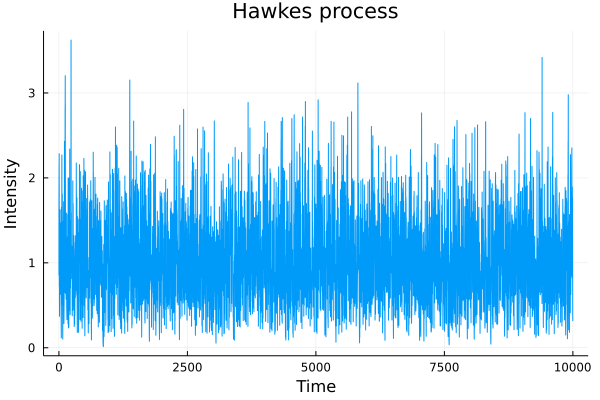

  0.006994 seconds (320.42 k allocations: 8.404 MiB)
Summary Stats:
Length:         10000
Missing Count:  0
Mean:           1.006026
Minimum:        0.019645
1st Quartile:   0.634102
Median:         0.943085
3rd Quartile:   1.311629
Maximum:        3.406658
Type:           Float64
describe(df.Intensity) = nothing


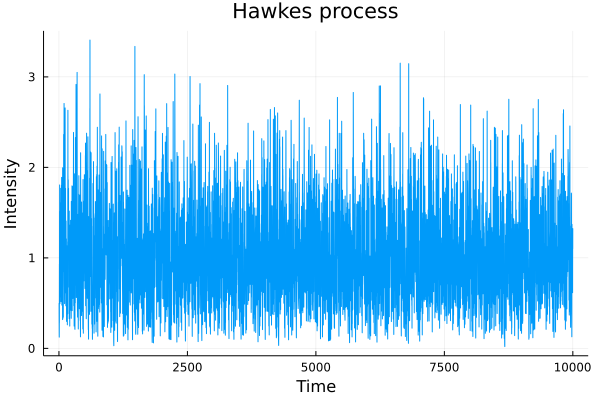

In [34]:
using Distributions
using DataFrames
using Plots

# Jump function
function jump(t, λ, τ, n)
    λ * exp(-t / τ) + n / τ
end

# No jump function
function no_jump(λ, τ, t)
    λ * exp(-t / τ)
end

# Event times generation
function generate_event_times(T, N)
    t = rand(Uniform(0.0, T), N)
    sort!(t)
    return t
end

# Hawkes process intensity PDF
function P_ss(ν, τ, n)
    return ν^(-1 + 2 * n * τ) * exp(-2 * τ * (1 - n) * ν)
end

# Time-rescaling theorem simulation for Hawkes process
function hawkes_simulation(T, N, K, n, ω, λ0)
    λt = zeros(N)
    λ = zeros(K, 2)
    tΔ = zeros(2)
    
    # Event times
    t = generate_event_times(T, N)
    
    # Time decay parameter τ
    τ = rand(Uniform(1.0, 3.0), K)
    
    # Branching ratio n
    n_values = fill(n / K, K)
    
    # Cumulative distribution function
    CDF = ζ(ω)
    
    # Initializations
    Δ = 0.0
    tΔ[2] = Δ
    m = ξ(ω, CDF)
    λ[:, 2] .= [jump(Δ, λ[i, 1], τ[i], n_values[i]) for i in 1:K]
    
    for i in 1:N
        while true
            if t[i] < tΔ[2]
                δ = t[i] - tΔ[1]
                λt[i] = λ0 + sum([no_jump(λ[i, 1], τ[i], δ) for i in 1:K])
                break
            else
                tΔ[1] = tΔ[2]
                λ[:, 1] .= λ[:, 2]
                Δ = rand(Exponential(1))
                tΔ[2] = tΔ[1] + Δ
                m = ξ(ω, CDF)
                λ[:, 2] .= [jump(Δ, λ[i, 1], τ[i], n_values[i]) for i in 1:K]
            end
        end
    end
    
    return t, λt
end

# Parameters
par = (
    K = 5,     # Number of exponential kernel functions
    n_values = [0.999, 0.99],  # Branching ratio values
    ω = 0.01,  # Exponential kernel parameter
    λ0 = 0.01  # Initial intensity
)

# Plot settings
plot_settings = (
    xlabel = "Time",
    ylabel = "Intensity",
    title = "Hawkes process",
    label = ""
)

# Perform simulation and plotting for each n value
for n in par.n_values
    # Simulation
    T = 10^4
    N = 10^4
    @time t, λt = hawkes_simulation(T, N, par.K, n, par.ω, par.λ0)

    # DataFrame
    df = DataFrame(Time = t, Intensity = λt)
    @show describe(df.Intensity)

    # Plot
    plt = plot(df.Time, df.Intensity; xlabel=plot_settings.xlabel, ylabel=plot_settings.ylabel, title=plot_settings.title, label=plot_settings.label)
    display(plt)
end



  0.222383 seconds (935.04 k allocations: 40.845 MiB, 9.76% gc time, 96.61% compilation time)


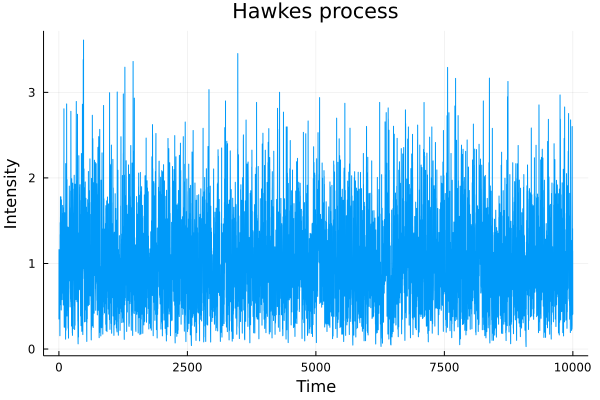

  0.006938 seconds (320.11 k allocations: 8.397 MiB)


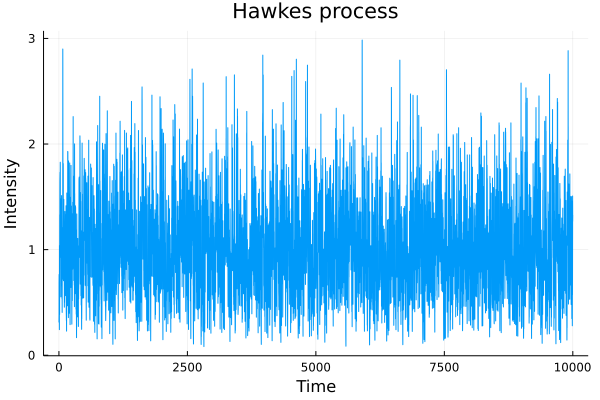

In [35]:
using Distributions
using DataFrames
using Plots

# Jump function
function jump(t, λ, τ, n)
    λ * exp(-t / τ) + n / τ
end

# No jump function
function no_jump(λ, τ, t)
    λ * exp(-t / τ)
end

# Event times generation
function generate_event_times(T, N)
    t = rand(Uniform(0.0, T), N)
    sort!(t)
    return t
end

# Hawkes process intensity PDF
function P_ss(ν, τ, n)
    return ν^(-1 + 2 * ν * τ) * exp(-2 * τ * (1 - n) * ν)
end

# Time-rescaling theorem simulation for Hawkes process
function hawkes_simulation(T, N, K, n, ω, λ0)
    λt = zeros(N)
    λ = zeros(K, 2)
    tΔ = zeros(2)
    
    # Event times
    t = generate_event_times(T, N)
    
    # Time decay parameter τ
    τ = rand(Uniform(1.0, 3.0), K)
    
    # Branching ratio n
    n_values = fill(n / K, K)
    
    # Cumulative distribution function
    CDF = ζ(ω)
    
    # Initializations
    Δ = 0.0
    tΔ[2] = Δ
    m = ξ(ω, CDF)
    λ[:, 2] .= [jump(Δ, λ[i, 1], τ[i], n_values[i]) for i in 1:K]
    
    for i in 1:N
        while true
            if t[i] < tΔ[2]
                δ = t[i] - tΔ[1]
                λt[i] = λ0 + sum([no_jump(λ[i, 1], τ[i], δ) for i in 1:K])
                break
            else
                tΔ[1] = tΔ[2]
                λ[:, 1] .= λ[:, 2]
                Δ = rand(Exponential(1))
                tΔ[2] = tΔ[1] + Δ
                m = ξ(ω, CDF)
                λ[:, 2] .= [jump(Δ, λ[i, 1], τ[i], n_values[i]) for i in 1:K]
            end
        end
    end
    
    return t, λt
end

# Parameters
par = (
    K = 5,     # Number of exponential kernel functions
    n_values = [0.999, 0.99],  # Branching ratio values
    ω = 0.01,  # Exponential kernel parameter
    λ0 = 0.01  # Initial intensity
)

# Plot settings
plot_settings = (
    xlabel = "Time",
    ylabel = "Intensity",
    title = "Hawkes process",
    label = ""
)

# Perform simulation and plotting for each n value
for n in par.n_values
    # Simulation
    T = 10^4
    N = 10^4
    @time t, λt = hawkes_simulation(T, N, par.K, n, par.ω, par.λ0)

    # DataFrame
    df = DataFrame(Time = t, Intensity = λt)

    # Plot
    plt = plot(df.Time, df.Intensity; xlabel=plot_settings.xlabel, ylabel=plot_settings.ylabel, title=plot_settings.title, label=plot_settings.label)
    display(plt)
end


$ν(t)=ν_0+n\sum_{i=1}^{N}(1/τ)e^{-(t-t_i)/τ}$\
$P_{ss}(t)=ν^{-1+2*ν_0*τ}*e^{-2*τ*(1-n)*ν}$\

## ・時間伸縮理論の参考コード

In [ ]:
@time using CSV                          # CSVファイルの操作のためのパッケージ
@time using DataFrames                   # データフレーム
@time using Distributions                # 確率分布
@time using NLsolve                      # 非線形方程式の近似根を求める
@time using Plots                        # グラフ描画
@time using Parameters                   # 数値モデルのパラメーターを処理するために使用するパッケージ
@time using QuadGK                       # 1次元の数値積分
@time using SpecialFunctions             # 特殊関数
@time using StatsBase                    # 統計にかかわる基本的な関数群が提供されているパッケージ

# 非線形方程式 ( Non-linear equations )
@inline fun(t,λ0,λ,τ,ω,K,Δ) = λ0*t+sum([λ[i,1]*τ[i]*(1-exp(-t/τ[i])) for i in 1:K])-Δ*ω/log(ω+1)

# 解の導出 Find solutions to non-linear equations
@inline function nls(func, params...; ini = [0.0]) 
    if typeof(ini) <: Number
        r = nlsolve((vout,vin)->vout[1]=func(vin[1],params...), [ini])
        v = r.zero[1]
    else
        r = nlsolve((vout,vin)->vout .= func(vin,params...), ini)
        v = r.zero
    end
    return v, r.f_converged
end

# Jump in [t,t+dt]
@inline jump(t,λ,τ,n,m) = λ*exp(-t/τ)+n*m/τ

# No jump during [t,t+dt]
@inline no_jump(λ,τ,t) = λ*exp(-t/τ)

# イベント時刻 (T,N) = (10^8,10^8) @time : 13.038416 seconds (2 allocations: 762.939 MiB, 0.72% gc time)
function time(T,N)
    t = rand(Uniform(0.0,T),N)
    sort!(t) # 昇順に並び替える
    return t
end;

# 手法 : 時間伸縮理論 ( Time-rescaling theorem )
function Time_Rescaling_Theorem(par,T=10^4,N=10^4) # (T,N) = (実時間,データ数)
    @unpack K,λ0,ω,n = par
    
    # 空の配列
    λt = zeros(N) # N = 10^8 @time 0.426187 seconds
    λ  = zeros(K,2)
    tΔ = zeros(2)
    
    # イベント発生時刻
    t = time(T,N)
    
    # 時間減衰項 τ 
    τ = rand(Uniform(1.0,3.0),K) #連続型
    #   rand(DiscreteUniform(min=1,max=3),K) #離散型
    
    # 分岐比 n 
    n = [n/K for i in 1:K]
    
    # 累積分布関数
    CDF = ζ(ω)
    
    # 解 (イベント発生時刻) の導出 
    Δ = nls(fun,λ0,λ[:,1],τ,ω,K,rand(Exponential(1)),ini=0.0)[1] # x[:,1] : 1列目を取る
    tΔ[2] = tΔ[1] + Δ
    m = ξ(ω,CDF)
    λ[:,2] = [jump(Δ,λ[i,1],τ[i],n[i],m) for i in 1:K]
    for i in 1:N
        while true
            if t[i] < tΔ[2]
                δ = t[i] - tΔ[1]
                λt[i] = λ0+sum([no_jump(λ[i,1],τ[i],δ) for i in 1:K])
                break
            else
                tΔ[1] = tΔ[2]
                λ[:,1] = λ[:,2]
                Δ = nls(fun,λ0,λ[:,1],τ,ω,K,rand(Exponential(1)),ini=0.0)[1]
                tΔ[2] = tΔ[1] + Δ
                m = ξ(ω,CDF)
                λ[:,2] = [jump(Δ,λ[i,1],τ[i],n[i],m) for i in 1:K]
            end
        end
    end
    t,τ,n,λt
end

# パラメータ
par = (
    K  = 5, # メモリーカーネル関数( 指数関数 )の数
    n  = 0.99, # 分岐比
    ω  = 0.01,
    λ0 = 0.01
)

@time t,τ,n,λt = Time_Rescaling_Theorem(par)

println("・分岐比 　n = $n")
println("・時間減衰 τ = $τ")

# データフレーム
df = DataFrame(Time=t,Intensity=λt) 
@show describe(df.Intensity)

# CSV
#CSV.write("/home/aaa/bbb/data_name.csv",df)

# Plot
plt = plot(df.Time,df.Intensity,xlabel = "Time",ylabel = "Intensity",title  = "Hawkes process",label  = "")
hist = histogram(df.Intensity,xlabel = "Intensity",ylabel = "Counts",title = "Frequency distribution",label = "")
plot(plot!(plt,x->mean(df.Intensity),label="Mean value",legendfontsize=5),hist,layout=(2,1))